<a href="https://colab.research.google.com/github/Max452/CarND-LaneLines-P1/blob/master/Copie_de_dogvscat.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [6]:
gpu_info = !nvidia-smi
gpu_info = '\n'.join(gpu_info)
if gpu_info.find('failed') >= 0:
  print('Not connected to a GPU')
else:
  print(gpu_info)

Tue May 24 14:46:18 2022       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 460.32.03    Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla P100-PCIE...  Off  | 00000000:00:04.0 Off |                    0 |
| N/A   35C    P0    27W / 250W |      0MiB / 16280MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

In [7]:
!pip install -q kaggle

In [8]:
from google.colab import files

uploaded = files.upload()

for fn in uploaded.keys():
  print('User uploaded file "{name}" with length {length} bytes'.format(
      name=fn, length=len(uploaded[fn])))
  
# Then move kaggle.json into the folder where the API expects to find it.
!mkdir -p ~/.kaggle/ && mv kaggle.json ~/.kaggle/ && chmod 600 ~/.kaggle/kaggle.json

Saving kaggle.json to kaggle.json
User uploaded file "kaggle.json" with length 64 bytes


In [9]:
from tensorflow.python.client import device_lib
device_lib.list_local_devices()

[name: "/device:CPU:0"
 device_type: "CPU"
 memory_limit: 268435456
 locality {
 }
 incarnation: 8107180774270547375
 xla_global_id: -1, name: "/device:GPU:0"
 device_type: "GPU"
 memory_limit: 16154099712
 locality {
   bus_id: 1
   links {
   }
 }
 incarnation: 9118528385404443008
 physical_device_desc: "device: 0, name: Tesla P100-PCIE-16GB, pci bus id: 0000:00:04.0, compute capability: 6.0"
 xla_global_id: 416903419]

In [ ]:
!kaggle datasets list 

ref                                                                   title                                             size  lastUpdated          downloadCount  voteCount  usabilityRating  
--------------------------------------------------------------------  -----------------------------------------------  -----  -------------------  -------------  ---------  ---------------  
muratkokludataset/date-fruit-datasets                                 Date Fruit Datasets                              408KB  2022-04-03 09:25:39           9037       1223  0.9375           
victorsoeiro/netflix-tv-shows-and-movies                              Netflix TV Shows and Movies                        2MB  2022-05-15 00:01:23           1362         55  1.0              
mdmahmudulhasansuzan/students-adaptability-level-in-online-education  Students Adaptability Level in Online Education    6KB  2022-04-16 04:46:28           6030        154  1.0              
muratkokludataset/acoustic-extinguisher-fire-

In [ ]:
! kaggle competitions list

ref                                                       deadline             category            reward  teamCount  userHasEntered  
--------------------------------------------------------  -------------------  ---------------  ---------  ---------  --------------  
mpetitions/contradictory-my-dear-watson                   2030-07-01 23:59:00  Getting Started     Prizes         39           False  
mpetitions/gan-getting-started                            2030-07-01 23:59:00  Getting Started     Prizes        136           False  
mpetitions/store-sales-time-series-forecasting            2030-06-30 23:59:00  Getting Started  Knowledge        909           False  
mpetitions/tpu-getting-started                            2030-06-03 23:59:00  Getting Started  Knowledge        163           False  
mpetitions/digit-recognizer                               2030-01-01 00:00:00  Getting Started  Knowledge       2113           False  
mpetitions/titanic                                     

In [10]:
!kaggle competitions download -c dogs-vs-cats

 98% 794M/812M [00:26<00:00, 47.7MB/s]
100% 812M/812M [00:26<00:00, 31.9MB/s]


In [11]:
!unzip dogs-vs-cats.zip

Archive:  dogs-vs-cats.zip
  inflating: sampleSubmission.csv    
  inflating: test1.zip               
  inflating: train.zip               


In [12]:
!rm dogs-vs-cats.zip sampleSubmission.csv

In [13]:
!unzip -qq  train.zip

In [14]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
tf.keras.applications.vgg16.preprocess_input
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Activation, Dense, Flatten, Dropout, BatchNormalization, Conv2D,MaxPooling2D, MaxPool2D, RandomFlip, RandomRotation, RandomZoom,Resizing, Rescaling
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import tensorflow_datasets as tfds
from sklearn.metrics import ConfusionMatrixDisplay
import itertools
import os
import shutil
import random
import glob
import matplotlib.pyplot as plt
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
%matplotlib inline

In [15]:
data_home="data/dogs-vs-cats"

In [16]:
if os.path.isdir(data_home) is True:
  shutil.rmtree(data_home)

In [17]:
if os.path.isdir(data_home) is False:
  os.makedirs(os.path.join(data_home, 'train/dogs'))
  os.makedirs(os.path.join(data_home, 'train/cats'))
  os.makedirs(os.path.join(data_home, 'valid/dogs'))
  os.makedirs(os.path.join(data_home, 'valid/cats'))
  os.makedirs(os.path.join(data_home, 'test/dogs'))
  os.makedirs(os.path.join(data_home, 'test/cats'))

In [18]:
!unzip -qq test1.zip

In [19]:
print(int(len(glob.glob('train/dog*'))),',',int(len(glob.glob('train/cat*'))),', ',int(len(glob.glob('train/dog*'))*0.9),', ', os.path.join(data_home, 'train/dogs'))


12500 , 12500 ,  11250 ,  data/dogs-vs-cats/train/dogs


In [20]:
nb_dog_train=int(len(glob.glob('train/dog*'))*0.85)
nb_dog_valid=int(len(glob.glob('train/dog*'))*0.1)
nb_dog_test=int(len(glob.glob('train/dog*'))*0.05)
nb_cat_train=int(len(glob.glob('train/cat*'))*0.85)
nb_cat_valid=int(len(glob.glob('train/cat*'))*0.1)
nb_cat_test=int(len(glob.glob('train/cat*'))*0.05)
for c in random.sample(glob.glob('train/dog*'),nb_dog_train):
  shutil.move(c,os.path.join(data_home, 'train/dogs'))
for c in random.sample(glob.glob('train/dog*'),nb_dog_valid):
  shutil.move(c,os.path.join(data_home, 'valid/dogs'))
for c in random.sample(glob.glob('train/dog*'),nb_dog_test):
  shutil.move(c,os.path.join(data_home, 'test/dogs'))
for c in random.sample(glob.glob('train/cat*'),nb_cat_train):
  shutil.move(c,os.path.join(data_home, 'train/cats'))
for c in random.sample(glob.glob('train/cat*'),nb_cat_valid):
  shutil.move(c,os.path.join(data_home, 'valid/cats'))
for c in random.sample(glob.glob('train/cat*'),nb_cat_test):
  shutil.move(c,os.path.join(data_home, 'test/cats'))


In [ ]:
def preprocess(x):
  return tf.keras.applications.vgg16.preprocess_input

In [23]:
builder = tfds.ImageFolder(data_home)

In [24]:
print(builder.info)

tfds.core.DatasetInfo(
    name='image_folder',
    version=1.0.0,
    description='Generic image classification dataset.',
    homepage='https://www.tensorflow.org/datasets/catalog/image_folder',
    features=FeaturesDict({
        'image': Image(shape=(None, None, 3), dtype=tf.uint8),
        'image/filename': Text(shape=(), dtype=tf.string),
        'label': ClassLabel(shape=(), dtype=tf.int64, num_classes=2),
    }),
    total_num_examples=25000,
    splits={
        'test': 1250,
        'train': 21250,
        'valid': 2500,
    },
    supervised_keys=('image', 'label'),
    citation="""""",
    redistribution_info=,
)



In [25]:
train_ds = builder.as_dataset(split='train', shuffle_files=True)
valid_ds = builder.as_dataset(split='valid', shuffle_files=True)
test_ds = builder.as_dataset(split='test', shuffle_files=True)

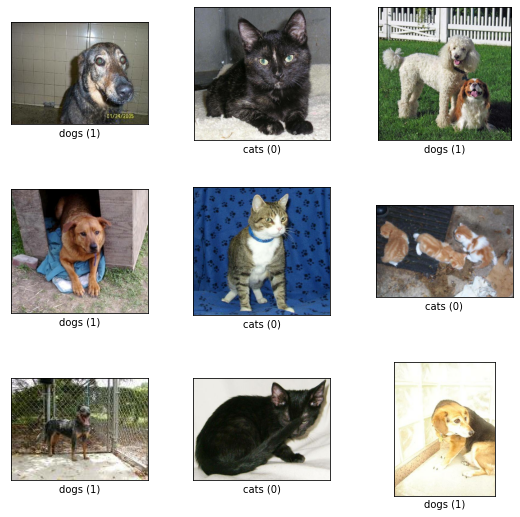

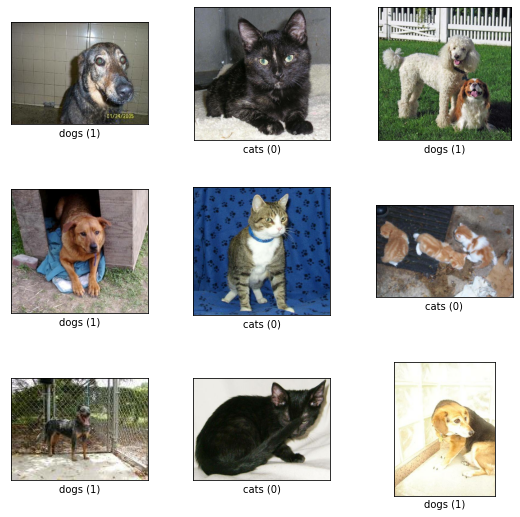

In [ ]:
tfds.show_examples(train_ds, builder.info)  

In [26]:
IMG_SIZE = 224

In [ ]:
#deprecated
def format_example(pair):
  print(pair['label'])
  image, label = pair['image'], pair['label']
  image = tf.cast(image, tf.float32)
  image = (image/127.5) - 1
  image = tf.image.resize(image, (IMG_SIZE, IMG_SIZE))
  return image, label




In [ ]:
train=train_ds.map(format_example)
valid=valid_ds.map(format_example)

Tensor("args_2:0", shape=(), dtype=int64)
Tensor("args_2:0", shape=(), dtype=int64)


In [ ]:
train_ds

<_OptionsDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [ ]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
NUM_CLASSES=builder.info.features['label'].num_classes

In [ ]:
train_batches = train.shuffle(buffer_size=SHUFFLE_BUFFER_SIZE).batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)
validation_batches = valid.batch(BATCH_SIZE).prefetch(buffer_size=tf.data.AUTOTUNE)

In [ ]:
train_batches.take(1)

In [ ]:
for image_batch, label_batch in train_batches.take(1):
   pass

image_batch.shape



TensorShape([32, 224, 224, 3])

In [27]:
# Create a data augmentation stage with horizontal flipping, rotations, zooms
data_augmentation = keras.Sequential(
    [
        RandomFlip("horizontal"),
        RandomRotation(0.1),
        RandomZoom(0.1),
    ]
)

In [ ]:
train_ds

<_OptionsDataset element_spec={'image': TensorSpec(shape=(None, None, 3), dtype=tf.uint8, name=None), 'label': TensorSpec(shape=(), dtype=tf.int64, name=None), 'image/filename': TensorSpec(shape=(), dtype=tf.string, name=None)}>

In [28]:
BATCH_SIZE = 128
SHUFFLE_BUFFER_SIZE = 1000
NUM_CLASSES=builder.info.features['label'].num_classes
resize_and_rescale = tf.keras.Sequential([
  Resizing(IMG_SIZE, IMG_SIZE),
  Rescaling(1./127.5, offset=-1)
  #preprocess_input()
  #layers.Rescaling(1./255)
])

def prepare(ds, shuffle=False, augment=False):
  # Resize and rescale all datasets.
  ds = ds.map(lambda x: (resize_and_rescale(x['image']), x['label']), 
              num_parallel_calls=tf.data.AUTOTUNE)
  #Test (si datatest >1G alors ne pas utiliser )
  #ds = ds.cache()
  if shuffle:
    ds = ds.shuffle(1000)

  # Batch all datasets.
  ds = ds.batch(BATCH_SIZE)

  # Use data augmentation only on the training set.
  if augment:
    ds = ds.map(lambda x, y : (data_augmentation(x, training=True), y), 
                num_parallel_calls=tf.data.AUTOTUNE)

  # Use buffered prefetching on all datasets.
  return ds.prefetch(buffer_size=tf.data.AUTOTUNE)

In [29]:
train=prepare(train_ds, shuffle=True, augment=True)
valid=prepare(valid_ds)
test=prepare(test_ds)

In [ ]:
train = train_ds.map(lambda x: (resize_and_rescale(x['image'])), num_parallel_calls=tf.data.AUTOTUNE)

In [2]:
def mon_modele():
  model = tf.keras.Sequential([
          Conv2D(16, 3, padding='same', activation='relu', name='layer1'),
          MaxPooling2D(),
          Dropout(0.2),
          Conv2D(32, 3, padding='same', activation='relu',name='layer2'),
          MaxPooling2D(),
          Dropout(0.2),
          Conv2D(64, 3, padding='same', activation='relu',name='layer3'),
          MaxPooling2D(),
          Dropout(0.3),
          Flatten(),
          Dense(128, activation='relu',name='layer4'),
          Dense(NUM_CLASSES,name='layer5')
          ])
  model.compile(optimizer='adam',
              loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
              metrics=['accuracy'])
  return model


In [35]:
callbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./training_checkpoints/dog_cat_{epoch}',
        save_weights_only=True),
    tf.keras.callbacks.EarlyStopping(
        monitor='loss',
        patience=5,
        verbose=1,
        restore_best_weights=True),
]

In [25]:
epochs=50
history = model.fit(
  train,
  validation_data=valid,
  epochs=epochs,
  callbacks=callbacks,
)

Epoch 1/50
167/167 [==============================] - 182s 995ms/step - loss: 0.7918 - accuracy: 0.5450 - val_loss: 0.6861 - val_accuracy: 0.5792
Epoch 2/50
167/167 [==============================] - 233s 1s/step - loss: 0.6674 - accuracy: 0.6134 - val_loss: 0.6895 - val_accuracy: 0.5392
Epoch 3/50
167/167 [==============================] - 232s 1s/step - loss: 0.6470 - accuracy: 0.6370 - val_loss: 0.6794 - val_accuracy: 0.5744
Epoch 4/50
167/167 [==============================] - 233s 1s/step - loss: 0.6476 - accuracy: 0.6324 - val_loss: 0.6618 - val_accuracy: 0.6088
Epoch 5/50
167/167 [==============================] - 168s 990ms/step - loss: 0.6181 - accuracy: 0.6752 - val_loss: 0.6123 - val_accuracy: 0.6800
Epoch 6/50
167/167 [==============================] - 233s 1s/step - loss: 0.5802 - accuracy: 0.7152 - val_loss: 0.5549 - val_accuracy: 0.7280
Epoch 7/50
167/167 [==============================] - 167s 986ms/step - loss: 0.5532 - accuracy: 0.7352 - val_loss: 0.5544 - val_accurac

In [26]:
y_predictions=model.predict(test)

In [27]:
#selectionne la categorie
predicted_categories = tf.argmax(y_predictions, axis=1)

In [30]:
true_categories = tf.concat([y for x, y in test], axis=0)

In [ ]:
tfds.features.ClassLabel.num_classes

In [ ]:
predicted_categories

<tf.Tensor: shape=(1250,), dtype=int64, numpy=array([0, 0, 0, ..., 1, 1, 0])>

In [ ]:
classes_name = builder.info.features['label'].names

In [ ]:
builder.info.features['label'].num_classes

2

In [ ]:
 features_dict['label'] = tfds.features.ClassLabel(names=labels)


NameError: ignored

In [ ]:
labels=['cats', 'dogs']

In [28]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

In [31]:
cm = confusion_matrix(true_categories, predicted_categories)

In [ ]:
disp = ConfusionMatrixDisplay(confusion_matrix=cm,display_labels=builder.info.features['label'].names)

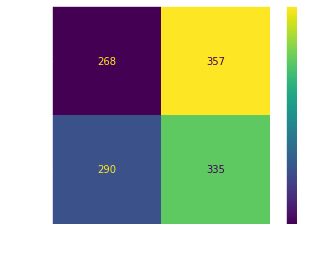

In [ ]:
disp.plot()

In [ ]:
 plt.show()

In [ ]:
builder.info.features['label']

ClassLabel(shape=(), dtype=tf.int64, num_classes=2)

In [ ]:
test

<PrefetchDataset element_spec=(TensorSpec(shape=(None, 224, 224, 3), dtype=tf.float32, name=None), TensorSpec(shape=(None,), dtype=tf.int64, name=None))>

In [ ]:
builder.info.features['label'].names == labels

True

In [32]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test,batch_size=128)
print("test loss, test acc:", results)

Evaluate on test data
10/10 [==============================] - 2s 190ms/step - loss: 0.3141 - accuracy: 0.8760
test loss, test acc: [0.314091295003891, 0.8759999871253967]


In [33]:
plt.style.use('dark_background')

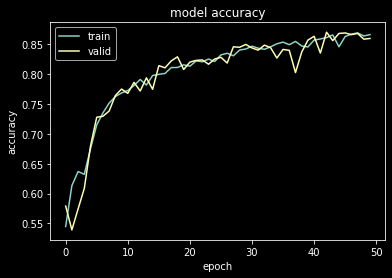

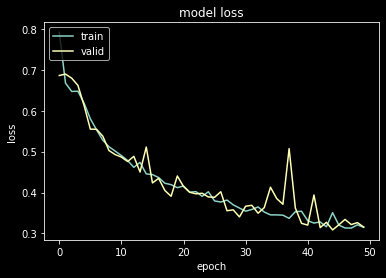

In [34]:
# summarize history for accuracy
plt.plot(history.history['accuracy'])
plt.plot(history.history['val_accuracy'])
plt.title('model accuracy')
plt.ylabel('accuracy')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(history.history['loss'])
plt.plot(history.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'valid'], loc='upper left')
plt.show()

In [ ]:
from google.colab import drive
drive.mount('/content/gdrive')

In [ ]:
!cp -fr training_checkpoints gdrive/MyDrive/.

**charger le modele avec les weight sauvegardés précédents**

In [48]:
checkpoint_save_dir_path='/content/gdrive/MyDrive/training_checkpoints'

os.listdir(checkpoint_save_dir_path)

['dog_cat_1.data-00000-of-00001',
 'checkpoint',
 'dog_cat_1.index',
 'dog_cat_2.data-00000-of-00001',
 'dog_cat_3.data-00000-of-00001',
 'dog_cat_2.index',
 'dog_cat_4.data-00000-of-00001',
 'dog_cat_3.index',
 'dog_cat_5.data-00000-of-00001',
 'dog_cat_4.index',
 'dog_cat_6.data-00000-of-00001',
 'dog_cat_5.index',
 'dog_cat_7.data-00000-of-00001',
 'dog_cat_6.index',
 'dog_cat_8.data-00000-of-00001',
 'dog_cat_7.index',
 'dog_cat_9.data-00000-of-00001',
 'dog_cat_8.index',
 'dog_cat_10.data-00000-of-00001',
 'dog_cat_9.index',
 'dog_cat_11.data-00000-of-00001',
 'dog_cat_10.index',
 'dog_cat_12.data-00000-of-00001',
 'dog_cat_11.index',
 'dog_cat_13.data-00000-of-00001',
 'dog_cat_12.index',
 'dog_cat_14.data-00000-of-00001',
 'dog_cat_13.index',
 'dog_cat_15.data-00000-of-00001',
 'dog_cat_14.index',
 'dog_cat_16.data-00000-of-00001',
 'dog_cat_15.index',
 'dog_cat_17.data-00000-of-00001',
 'dog_cat_16.index',
 'dog_cat_18.data-00000-of-00001',
 'dog_cat_17.index',
 'dog_cat_19.dat

In [56]:
checkpoint_path_last_epoch = checkpoint_save_dir_path+'/dog_cat_50'
print(checkpoint_path_last_epoch)

/content/gdrive/MyDrive/training_checkpoints/dog_cat_50


In [33]:
model = mon_modele()

In [37]:
loss, acc = model.evaluate(test, test_labels, verbose=2)

NameError: ignored

In [38]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test,batch_size=128,verbose=2)
print("test loss, test acc:", results)

Evaluate on test data
10/10 - 12s - loss: 0.6953 - accuracy: 0.5000 - 12s/epoch - 1s/step
test loss, test acc: [0.695341944694519, 0.5]


In [58]:
model.load_weights(checkpoint_path_last_epoch)

In [59]:
# Evaluate the model on the test data using `evaluate`
print("Evaluate on test data")
results = model.evaluate(test,batch_size=128,verbose=2)
print("test loss, test acc:", results)

Evaluate on test data
10/10 - 5s - loss: 0.2988 - accuracy: 0.8728 - 5s/epoch - 487ms/step
test loss, test acc: [0.298774391412735, 0.8727999925613403]


In [60]:
model.summary()

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 layer1 (Conv2D)             (None, 224, 224, 16)      448       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 112, 112, 16)     0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 112, 112, 16)      0         
                                                                 
 layer2 (Conv2D)             (None, 112, 112, 32)      4640      
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 56, 56, 32)       0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 56, 56, 32)       

Keras hypetuner

In [1]:
pip install -q -U keras-tuner

     |████████████████████████████████| 133 kB 4.3 MB/s 


In [31]:
import keras_tuner as kt

In [37]:
def model_builder(hp):
  model = keras.Sequential() 
  hp_conv1 = hp.Int('conv1', min_value=16, max_value=64, step=16)
  model.add(Conv2D(hp_conv1, 3, padding='same', activation='relu', name='layer1'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  hp_conv2 = hp.Int("conv2", min_value=32, max_value=96, step=32)
  model.add(Conv2D(hp_conv2, 3, padding='same', activation='relu',name='layer2'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.2))
  hp_conv3 = hp.Int("conv3", min_value=64, max_value=128, step=32)
  model.add(Conv2D(hp_conv3, 3, padding='same', activation='relu',name='layer3'))
  model.add(MaxPooling2D())
  model.add(Dropout(0.3))
  model.add(Flatten())
  hp_units = hp.Int('units', min_value=128, max_value=512, step=32)
  model.add(Dense(hp_units, activation='relu',name='layer4'))
  model.add(Dense(NUM_CLASSES,name='layer5'))
  hp_learning_rate = hp.Choice('learning_rate', values=[1e-2, 1e-3, 1e-4])
  model.compile(optimizer=keras.optimizers.Adam(learning_rate=hp_learning_rate),
            loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
            metrics=['accuracy'])
  return model

In [38]:
tuner = kt.Hyperband(model_builder,
                     objective='val_accuracy',
                     max_epochs=10,
                     factor=3,
                     directory='hypetunedogcat',
                     project_name='dogcat')

In [39]:
stop_early = tf.keras.callbacks.EarlyStopping(monitor='val_loss', patience=5)

In [ ]:
tuner.search(train, epochs=50, validation_data=valid, callbacks=[stop_early])

Trial 9 Complete [00h 06m 44s]
val_accuracy: 0.7296000123023987

Best val_accuracy So Far: 0.7296000123023987
Total elapsed time: 01h 16m 41s

Search: Running Trial #10

Value             |Best Value So Far |Hyperparameter
48                |48                |conv1
96                |64                |conv2
96                |96                |conv3
352               |288               |units
0.001             |0.001             |learning_rate
2                 |2                 |tuner/epochs
0                 |0                 |tuner/initial_epoch
2                 |2                 |tuner/bracket
0                 |0                 |tuner/round

Epoch 1/2
167/167 [==============================] - 173s 1s/step - loss: 0.8779 - accuracy: 0.4984 - val_loss: 0.6932 - val_accuracy: 0.5000
Epoch 2/2
167/167 [==============================] - 235s 1s/step - loss: 0.6931 - accuracy: 0.5083 - val_loss: 0.6931 - val_accuracy: 0.5000


In [ ]:
# Get the optimal hyperparameters
best_hps=tuner.get_best_hyperparameters(num_trials=1)[0]

print(f"""
The hyperparameter search is complete. The optimal number of filters in the first convnet is {best_hps.get('conv1')} and The optimal number of filters in the second convnet is {best_hps.get('conv2')} and The optimal number of filters in the first convnet is {best_hps.get('conv3')} and the optimal number of units in the first densely-connected
layer is {best_hps.get('units')} and the optimal learning rate for the optimizer
is {best_hps.get('learning_rate')}.
""")

In [ ]:
# Build the model with the optimal hyperparameters and train it on the data for 50 epochs
model = tuner.hypermodel.build(best_hps)
epochs=50
history = model.fit(
  train,
  validation_data=valid,
  epochs=epochs,
  callbacks=callbacks,
)

val_acc_per_epoch = history.history['val_accuracy']
best_epoch = val_acc_per_epoch.index(max(val_acc_per_epoch)) + 1
print('Best epoch: %d' % (best_epoch,))